In [1]:
import os
import pandas as  pd
import sys 
import numpy as np
import matplotlib as plt
import seaborn as sns
import bamboolib as bam
import plotly.express as px

sys.path.append("../../../")

from cropseq import cfg



In [2]:
dts_file = cfg.resource("dataset.pickle")
df = pd.read_pickle(dts_file)

df_lus = df[["2021","land_usage"]].drop_duplicates()
df_lus.columns = ["code","land_usage"]



In [3]:
# find rows with empty values in any column (code == 0 --> sample with invalid land usage)
missing_values = df[df.isin([0]).any(axis=1)].shape[0]
print("Samples with no-data in any of the columns: {}".format(missing_values))


Samples with no-data in any of the columns: 45158


In [4]:
print("Number of missing values per year")
df[df.isin([0])].count()

Number of missing values per year


x                 0
y                 0
2011          11067
2012          10528
2013          10352
2014           6429
2015           4218
2016           8253
2017           4663
2018              0
2019              0
2020              0
2021              0
cubierta          0
land_usage        0
dtype: int64

# Category review

In [5]:
# remove missing vlaues
df = df[~df.isin([0]).any(axis=1)]

In [6]:
# group data by year
cols = [str(x) for x in list(range(2011,2022))]
cols.insert(0, "land_usage") 
df_summ = df[cols].groupby(by="land_usage").sum()
import pandas as pd; import numpy as np
df_summ = df_summ.reset_index()
df_summ.reset_index()

    index                                    land_usage        2011  \
0       0                         Abandoned woody crops    146857.0   
1       1                                       Alfalfa   2004900.0   
2       2                           Artificial surfaces   3046692.0   
3       3                                     Bare soil  19628447.0   
4       4                                        Barley  14012594.0   
5       5                                          Beet    202056.0   
6       6                               Bodies of water     17182.0   
7       7                  Broad-leaved deciduous trees   8030035.0   
8       8                  Broad-leaved evergreen trees    211980.0   
9       9                               Castanea sativa    197583.0   
10     10                              Coniferous trees   1480582.0   
11     11                                   Fruit trees    235266.0   
12     12                                     Grassland  25904051.0   
13    

<AxesSubplot:xlabel='2021', ylabel='land_usage'>

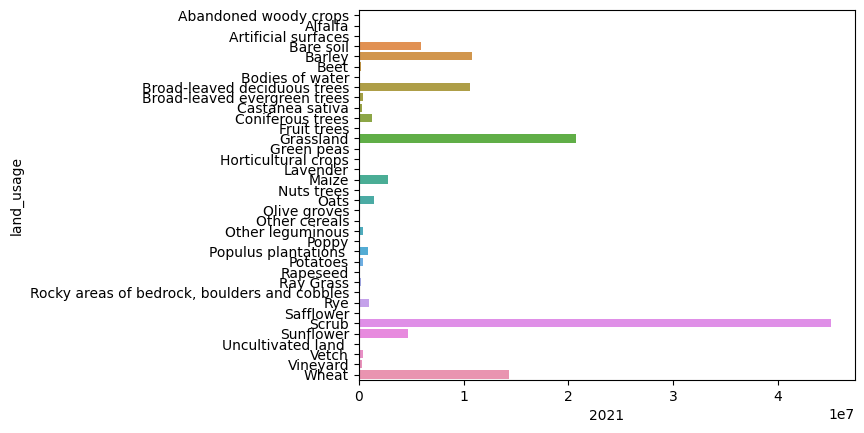

In [7]:
sns.barplot(x="2021", y="land_usage", data=df_summ)

Not cultivated areas, represented by scrub, bare soil and grassland representes most of the  analyzed points in year 2021.

In [8]:
print("Percentage of sample points with not cultivated area: {:0%}".format(df[df.land_usage.isin(["Bare soil", "Scrub", "Grassland"])].shape[0]/df.shape[0]))

Percentage of sample points with not cultivated area: 36.702298%


<AxesSubplot:ylabel='land_usage'>

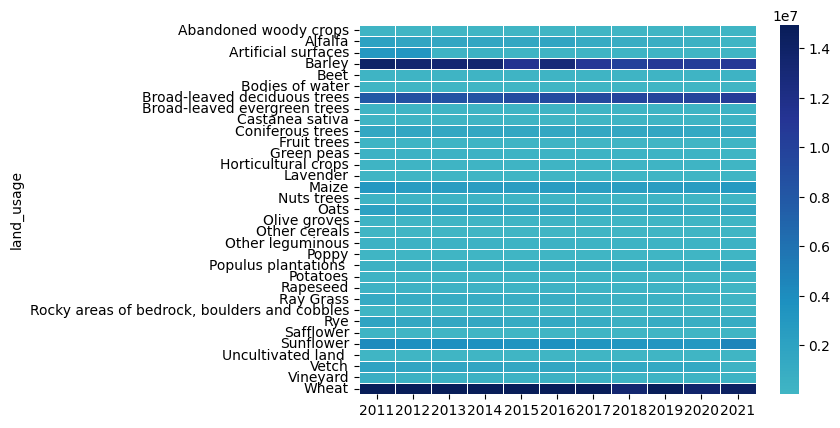

In [9]:
#Lets exclude not cultivated areas  and represent the land usages by year
uncultivated_lu =["Bare soil", "Scrub", "Grassland"]
df_summ = df_summ.set_index("land_usage")
df_summ = df_summ[~ df_summ.index.isin(uncultivated_lu)]

# df.style.background_gradient(cmap='Blues')
yticklabels = df_summ.index.values
sns.heatmap(df_summ, annot=False, linewidths=0.5, cmap="YlGnBu", fmt = "d", yticklabels= yticklabels, robust=True, center = 0)


In [10]:
# Lets check how much the data tends to change between years,
# lets diff each column with the previous one to measure the number of changes in each year

df_changes = None
for year in range(2012, 2022):
    # diff column
    changes_mask = df[str(year)]!= df[str(year-1)]
    if df_changes is None:
        df_changes = changes_mask
    else:
        df_changes = pd.concat([df_changes, changes_mask], axis=1)

df_changes.columns = [str(column) for column in list(range(2012, 2022))]

print("Percentage of change in each year resp. the previous one")
100 * df_changes.sum()/len(df_changes)


Percentage of change in each year resp. the previous one


2012    65.370359
2013    64.254434
2014    57.882627
2015    67.419147
2016    64.717039
2017    67.450765
2018    68.363060
2019    66.681591
2020    67.867545
2021    63.843442
dtype: float64

The change seems to be stable and around the 66%, except for year 2014.

In [11]:
#Lets make the same calc but excluding the land usages that are expected to not change (vineyard, artificial areas, water bodies, etc.)
stable_land_usages = [
    'Abandoned woody crops',
    'Artificial surfaces',
    'Bodies of water',
    'Broad-leaved deciduous trees',
    'Broad-leaved evergreen trees',
    'Castanea sativa',
    'Coniferous trees',
    'Fruit trees',
    'Nuts trees',
    'Olive groves',
    'Populus plantations',
    'Rocky areas',
    'Vineyard',
]
# get  codes:
stable_lu_table = df[df.land_usage.isin(stable_land_usages)][["2021","land_usage"]].drop_duplicates()
stable_lu_codes = stable_lu_table["2021"].values.tolist()
stable_lu_codes

[13, 120, 3, 203, 10, 15, 12, 14, 204, 255, 243]

In [12]:
df[df.isin(stable_lu_codes).any(axis=1)].shape


(679023, 15)

In [13]:
# remove rows that include any of the stable land usages
df_variable = df[~df.isin(stable_lu_codes).any(axis=1)]
print("Total sample: {} samples with variable land usages: {}".format(df.shape[0], df_variable.shape[0]))

df_changes = None
for year in range(2012, 2022):
    # diff column
    changes_mask = df_variable[str(year)]!= df_variable[str(year-1)]
    if df_changes is None:
        df_changes = changes_mask
    else:
        df_changes = pd.concat([df_changes, changes_mask], axis=1)

df_changes.columns = [str(column) for column in list(range(2012, 2022))]

print("Percentage of change in each year resp. the previous one")
100 * df_changes.sum()/len(df_changes)

Total sample: 2090553 samples with variable land usages: 1411530
Percentage of change in each year resp. the previous one


2012    67.328643
2013    66.976331
2014    64.965321
2015    70.564919
2016    70.169816
2017    71.206351
2018    72.044448
2019    73.068869
2020    72.261234
2021    70.888256
dtype: float64

The percentage raises around a 5% up to 70% as mean.

In [60]:
print("What area the most common combinations when passing from one year to another?")

columns = ["prev", "next"]

df_pairs = None
for year_pairs in [(str(year), str(year-1)) for year in range(2012, 2022)]:
    diff_pairs = df[[year_pairs[0], year_pairs[1]]]
    diff_pairs.columns = columns
    if df_pairs is None:
        df_pairs = diff_pairs
    else: 
        df_pairs = pd.concat([df_pairs, diff_pairs])
# df_pairs = df_pairs.drop_duplicates()


What area the most common combinations when passing from one year to another?


In [61]:
# remove elements with no variation prev == next:
df_pairs = df_pairs[~(df_pairs.prev == df_pairs.next)]

In [83]:
count_serie = df_pairs.groupby(by=["prev", "next"])["prev"].count()
count_serie.name = "count"
df_counts = count_serie.reset_index()

df_counts = df_counts.merge(df_lus, how="left", left_on="prev", right_on="code")\
        .merge(df_lus, how="left", left_on="next", right_on="code")
df_counts = df_counts.drop(["code_x", "code_y"], axis=1)
df_counts.columns = ["prev", "next","count", "from_land_usage", "to_land_usage"]

df_counts["perc"] = df_counts["count"]*100 /df_counts["count"].sum()
df_counts.sort_values(by="count", ascending=False).head(20)

      prev  next    count               from_land_usage  \
599     32    31  1027971                        Barley   
563     31    32   788529                         Wheat   
568     31    50   671176                         Wheat   
562     31    20   654320                         Wheat   
527     20    31   625059                     Bare soil   
770     50    31   529831                     Sunflower   
771     50    32   435332                     Sunflower   
528     20    32   386004                     Bare soil   
604     32    50   328607                        Barley   
598     32    20   281742                        Barley   
1043   201    85   239532                         Scrub   
943     85   201   224452                     Grassland   
567     31    45   179472                         Wheat   
554     31    11   156831                         Wheat   
944     85   203   132183                     Grassland   
1077   203    85   127773  Broad-leaved deciduous trees 

In [95]:
top_20_perc = df_counts.sort_values(by="count", ascending=False).head(20)["perc"].sum()

print("""
Top 20 possible combinations include the {:.2f}% of the combinations 
that appear in the full dataset.
""".format(top_20_perc))



Top 20 possible combinations include the 53.13% of the combinations 
that appear in the full dataset.



In [105]:
print("""
We could develop a very basic bayesian network using probabilities extracted 
from this dataset.
For example the prob. of passing from Wheat to any other land usage is:
""")

df_wheat = df_counts[df_counts["from_land_usage"] == "Wheat"]
df_wheat["perc"] = df_wheat["count"]*100 /df_wheat["count"].sum()
df_wheat.sort_values(by="perc", ascending=False).head(20)



We could develop a very basic bayesian network using probabilities extracted 
from this dataset.
For example the prob. of passing from Wheat to any other land usage is:



     prev  next   count from_land_usage                 to_land_usage  \
563    31    32  788529           Wheat                        Barley   
568    31    50  671176           Wheat                     Sunflower   
562    31    20  654320           Wheat                     Bare soil   
567    31    45  179472           Wheat              Other leguminous   
554    31    11  156831           Wheat                     Ray Grass   
548    31     4  122674           Wheat            Uncultivated land    
576    31   201  101217           Wheat                         Scrub   
551    31     8   64763           Wheat                         Vetch   
566    31    35   62475           Wheat                 Other cereals   
573    31    85   59556           Wheat                     Grassland   
550    31     7   48025           Wheat                    Green peas   
570    31    52   38116           Wheat                      Potatoes   
546    31     2   36692           Wheat            

So **25% of the times** a farmer grows wheat, next year he/she grows barley.

This can be used as our base model, the model 0 defined as a probability table that defines a conditional distribution as p(land_usage<sub>t+1</sub> | land_usage<sub>t</sub>).

This will be the model that our HMM, CDF  or LSTM has to improve, so lets check how good it is

# Estimating base model
The last table gives us the conditional probability of passing from one land usage to others, this can be used to create the base model to beat.

To be fair, first we need to create the model using just the 2011-2020 data and use it to predict the land usages in year 2021.

In [140]:

columns = ["prev", "next"]

df_pairs = None
for year_pairs in [(str(year), str(year-1)) for year in range(2012, 2021)]:
    diff_pairs = df[[year_pairs[0], year_pairs[1]]]
    diff_pairs.columns = columns
    if df_pairs is None:
        df_pairs = diff_pairs
    else: 
        df_pairs = pd.concat([df_pairs, diff_pairs])

        
count_serie = df_pairs.groupby(by=["prev", "next"])["prev"].count()
count_serie.name = "count"
df_counts = count_serie.reset_index()

df_counts = df_counts.merge(df_lus, how="left", left_on="prev", right_on="code")\
        .merge(df_lus, how="left", left_on="next", right_on="code")
df_counts = df_counts.drop(["code_x", "code_y"], axis=1)
df_counts.columns = ["prev", "next","count", "from_land_usage", "to_land_usage"]

# we have to calculate the percentaje per each group so the marginal distribution 
# adds up 1.00 per each land_usage
df_counts["perc"] = df_counts["count"]*100 /df_counts["count"].sum()

df_counts.sort_values(by="count", ascending=False).head(20)        


      prev  next    count               from_land_usage  \
899     85    85  1193040                     Grassland   
572     32    32  1170910                        Barley   
537     31    31  1083826                         Wheat   
571     32    31   918321                        Barley   
1001   201   201   791259                         Scrub   
538     31    32   677697                         Wheat   
543     31    50   606558                         Wheat   
536     31    20   544038                         Wheat   
504     20    31   525535                     Bare soil   
736     50    31   491287                     Sunflower   
34       3     3   459703           Artificial surfaces   
737     50    32   394473                     Sunflower   
505     20    32   316683                     Bare soil   
776     51    51   304453                         Maize   
577     32    50   303446                        Barley   
1070   204   204   255883  Broad-leaved evergreen trees 

In [145]:
df_total_per_group = df_counts.groupby(by=["from_land_usage"])["count"].sum()
df_total_per_group = df_total_per_group.reset_index(0)
df_total_per_group.rename(columns = {"count":"total_count"}, inplace = True)
df_total_per_group

                                 from_land_usage  total_count
0                          Abandoned woody crops         1496
1                                        Alfalfa       367183
2                            Artificial surfaces       626015
3                                      Bare soil      1578703
4                                         Barley      3143697
5                                           Beet        64097
6                                Bodies of water         6202
7                   Broad-leaved deciduous trees       639621
8                   Broad-leaved evergreen trees       551976
9                                Castanea sativa        13952
10                              Coniferous trees       194857
11                                   Fruit trees        39668
12                                     Grassland      1919004
13                                    Green peas       104571
14                           Horticultural crops        92429
15      

In [150]:
df_probs = df_counts.merge(df_total_per_group, how="left", left_on="from_land_usage", right_on="from_land_usage")
df_probs["perc"] = df_probs["count"] / df_probs["total_count"]


In [153]:
# to make sure everything is ok, lets summ each group to make sure the prob = 1.0
df_probs.groupby(by="from_land_usage")["perc"].sum()

from_land_usage
Abandoned woody crops                           1.0
Alfalfa                                         1.0
Artificial surfaces                             1.0
Bare soil                                       1.0
Barley                                          1.0
Beet                                            1.0
Bodies of water                                 1.0
Broad-leaved deciduous trees                    1.0
Broad-leaved evergreen trees                    1.0
Castanea sativa                                 1.0
Coniferous trees                                1.0
Fruit trees                                     1.0
Grassland                                       1.0
Green peas                                      1.0
Horticultural crops                             1.0
Lavender                                        1.0
Maize                                           1.0
Nuts trees                                      1.0
Oats                                            

In [159]:
df_probs[(df_probs.from_land_usage == "Wheat") & (df_probs.to_land_usage == "Vineyard")]["perc"]

531    0.001177
Name: perc, dtype: float64

In [188]:
print("""
With this table, we can calculate the probability for 2021 of passing 
from wheat to Vineyard: {:.2%}
""".format(df_probs[(df_probs.from_land_usage == "Wheat") & (df_probs.to_land_usage == "Vineyard")]["perc"].tolist()[0])
     )
print("""
Passing from Wheat to sunflower: {:.2%}
""".format(df_probs[(df_probs.from_land_usage == "Wheat") & (df_probs.to_land_usage == "Sunflower")]["perc"].tolist()[0])
     )
print("""
Or staying in Wheat: {:.2%}
""".format(df_probs[(df_probs.from_land_usage == "Wheat") & (df_probs.to_land_usage == "Wheat")]["perc"].tolist()[0])
     )


With this table, we can calculate the probability for 2021 of passing 
from wheat to Vineyard: 0.12%


Passing from Wheat to sunflower: 15.43%


Or staying in Wheat: 27.57%



One we have a CDF (conditional distribution function) we can simulate the next year using these probabilities. We sort the CDF and for each land usage, we take a random number in [0-1] to chose the next year land usage.

In [279]:
df_probs = df_probs.sort_values(by=["from_land_usage", "perc"], ascending= [True, False])
cpd = {}

for idx, row in df_probs.iterrows():
    lu_probs = cpd.get(row["from_land_usage"], [])
    if len(lu_probs) == 0:
        lu_probs = [[],[]]
    lu_probs[0].append(row["to_land_usage"])
    lu_probs[1].append(row["perc"])
    
    cpd[row["from_land_usage"]] = lu_probs

print("""
Top 5 probs from Vineyard: {} --> {}
""".format(cpd["Vineyard"][0][:5], cpd["Vineyard"][1][:3])
     )



Top 5 probs from Vineyard: ['Vineyard', 'Bare soil', 'Sunflower', 'Barley', 'Scrub'] --> [0.8312890256702187, 0.029397114546457225, 0.027818298258409976]



In [332]:
# function to simulate data using the cdf
def simulate(cpd, land_usage):
    import random 
    
    probs = cpd[land_usage]
    rand_f = random.random()
    acumm = 0
    for i, threshold in enumerate(probs[1]):
        acumm += threshold
        # find the first value greater that the random number
        if acumm >= rand_f:
            return probs[0][i] # land usage name
    return probs[0][-1] #return last one



In [335]:
print("An example of simulation")
[simulate(cpd, 'Vineyard') for i in range(0,10)]

['Vineyard',
 'Vineyard',
 'Vineyard',
 'Vineyard',
 'Vineyard',
 'Vineyard',
 'Vineyard',
 'Wheat',
 'Bare soil',
 'Vineyard']

In [359]:
# create code to description map:
lu_mapping = {}
for rec in df_lus.to_dict(orient="records"):
    lu_mapping[rec["code"]] = rec["land_usage"]

def appf(x):
    lu_name = lu_mapping[x]
    return simulate(cpd, lu_name)    

In [397]:
"""
to make the next year predition (2021) we have to run the 
simulation over the full data set, we take the 2020 column and 
predict the next year using de CPD.
"""

y_pred = df["2020"].apply(appf).values.tolist()

In [430]:
y_true = df["2021"].apply(lambda x: lu_mapping[x]).values.tolist()

In [434]:
from sklearn.metrics import f1_score
print("""
      F1-score obtained for this prediction: {:.2}
      """.format(f1_score(y_true, y_pred, average="weighted"))
    )


      F1-score obtained for this prediction: 0.29
      


In [418]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
labels = sorted(lu_mapping.values())
cm = confusion_matrix(y_true, y_pred, labels = labels, normalize= "true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)

                    

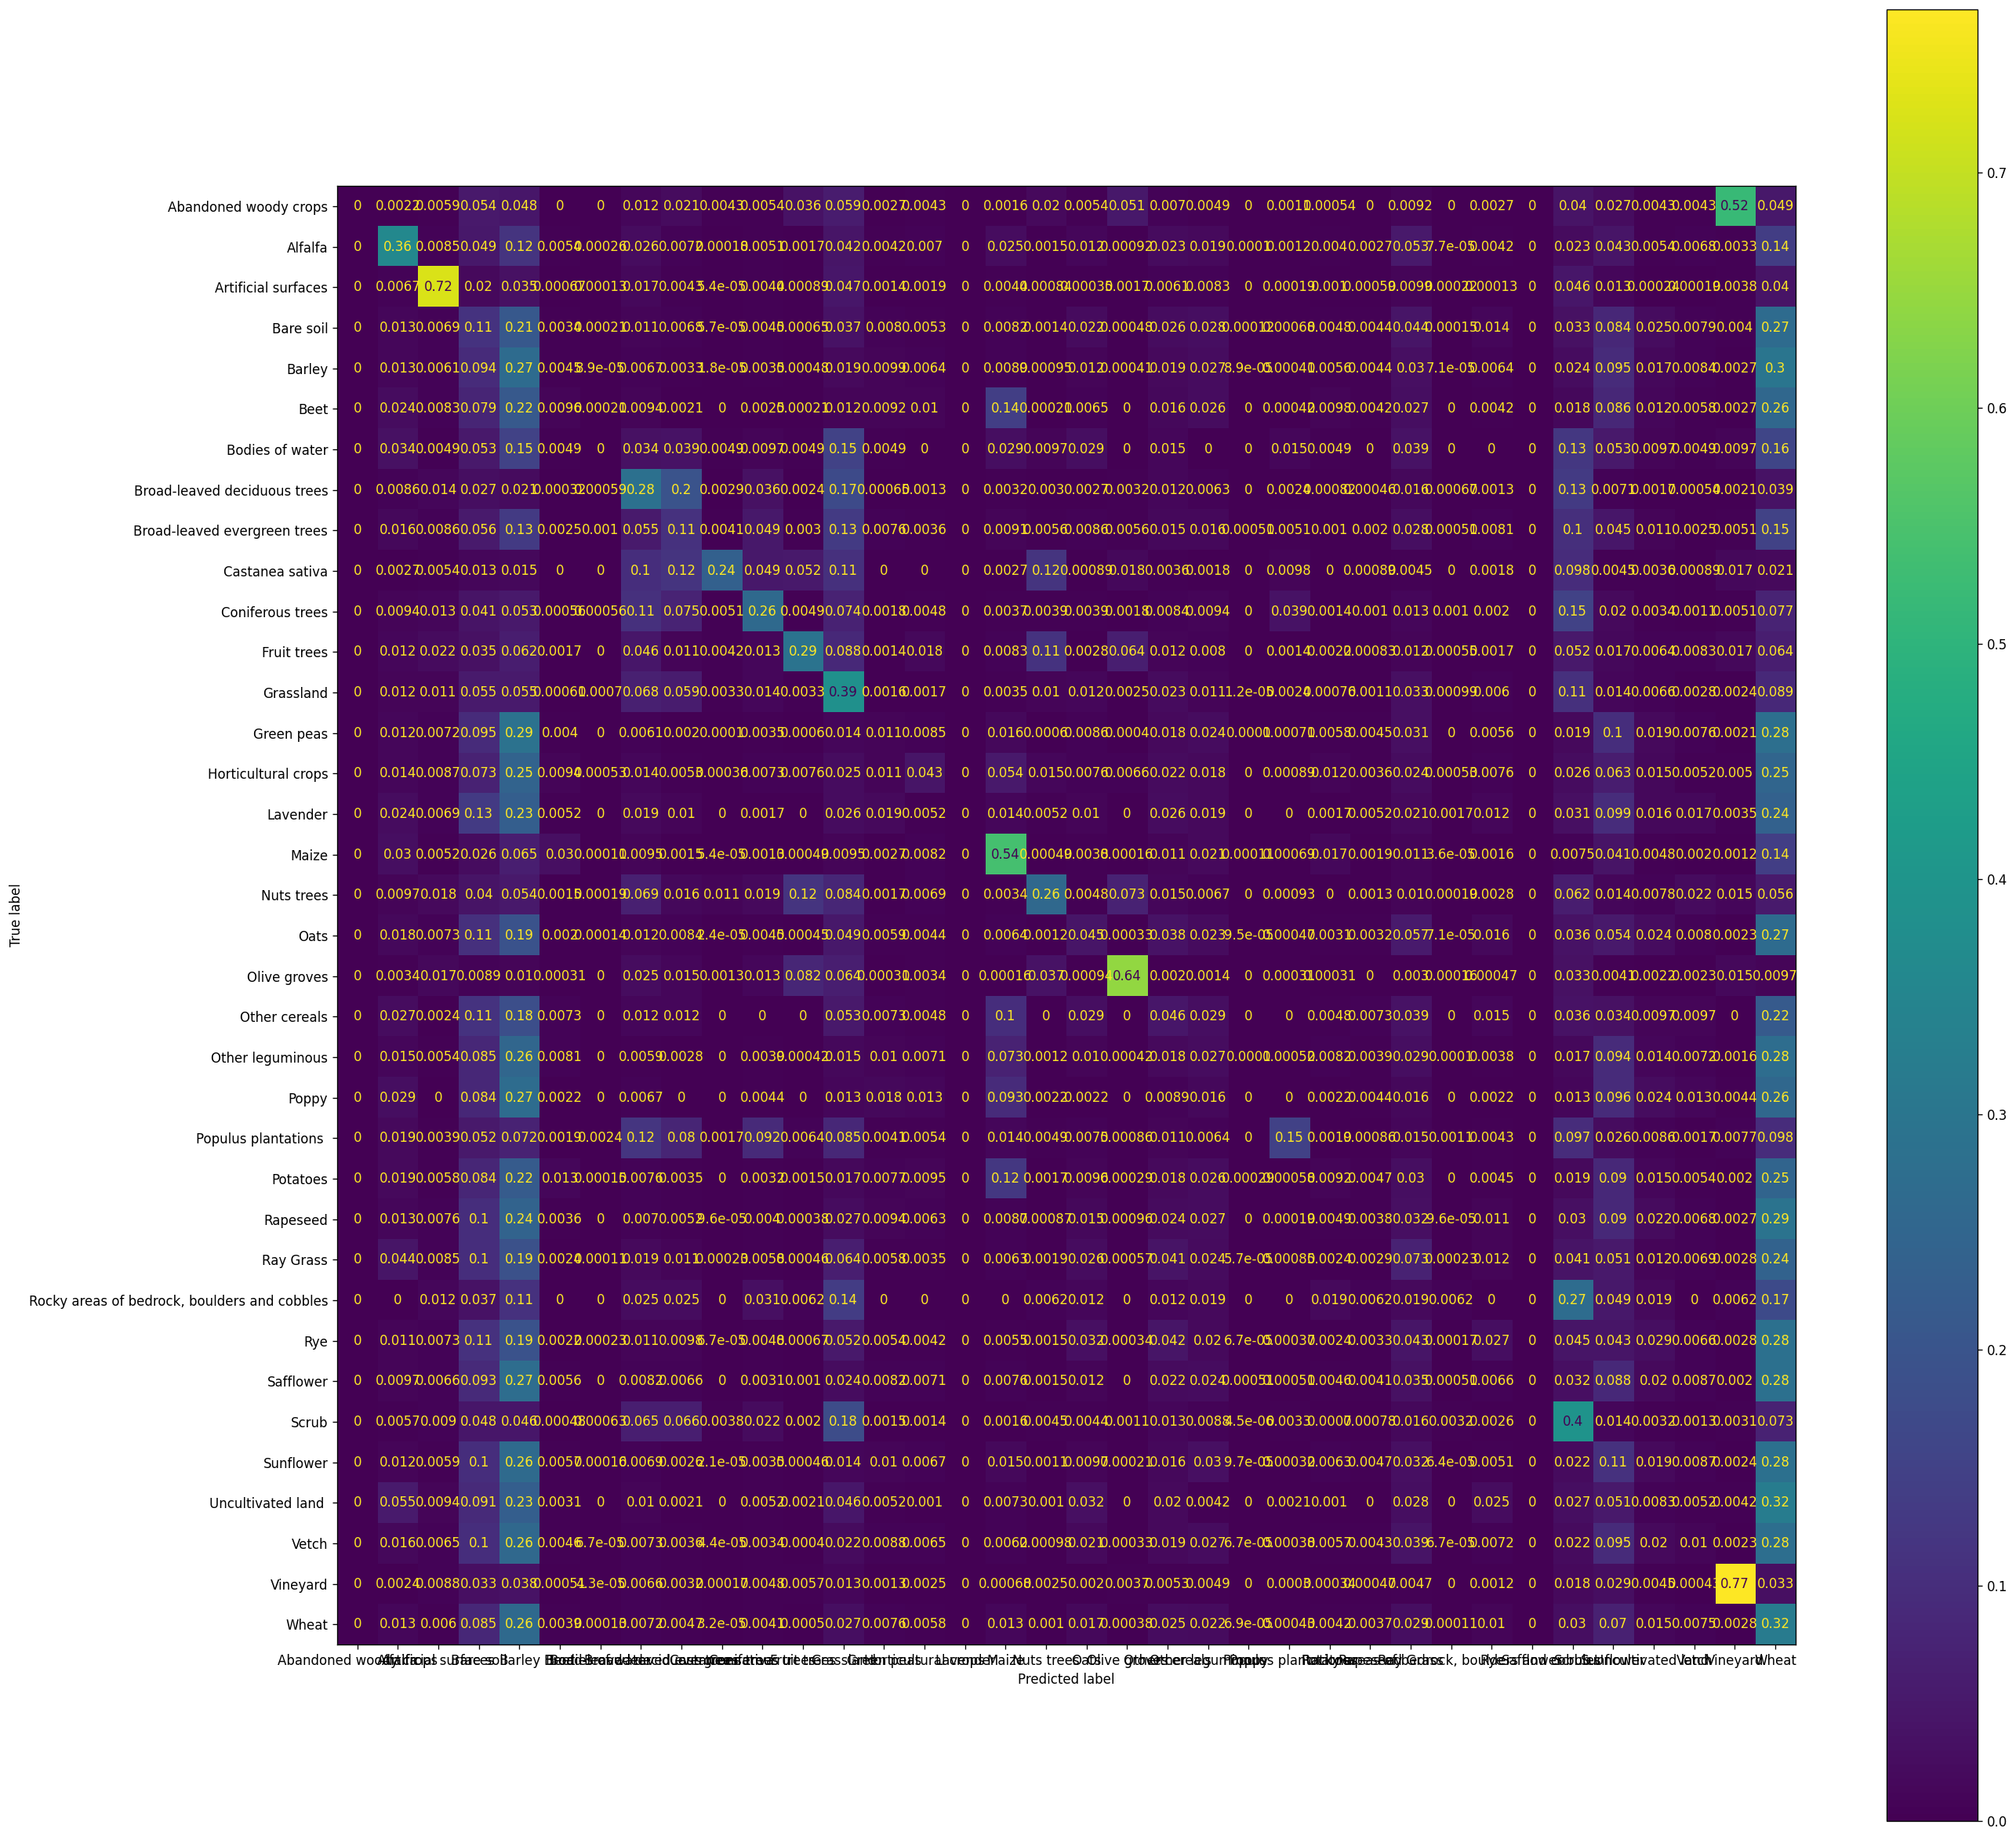

In [429]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(25, 25), dpi=120)

disp.plot(ax = ax)

As we can see the f1-score of the classifier is really low, we should repeat the experimient calculating the score using CV, but the metric it is not expected to increase too much.

The confusion matrix shows that the classifier only performs well in stable land usages (vineyard, olive, artificial surfaces, trees,..) etc.

So predicting the next usage based in last year is not an acceptable option, as expected with a percentage of variation around 70% as we have seen.